In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            #why do like this?
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= torch.rand(self._n).to(device)

            #dI = torch.rand(self._n, requires_grad=True).to(device) < dI 
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            

            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI

In [2]:
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

tensor(5000., device='cuda:0')



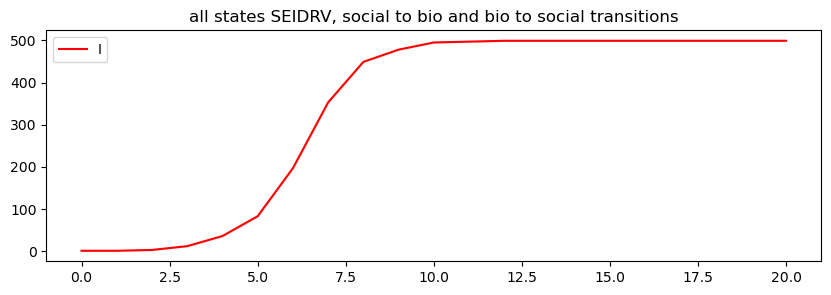

In [60]:
n = 500 # population
avgDegree = 10  #every individual will have 10 contacts on average
pinf = 0.2  #it is the first parameter we are going to fit
time_horizon = 20

#create  dense contacts
contacts = generate_random_network(n, avgDegree)
contacts = contacts.coalesce()#make pairs unique
print(contacts.values().sum())
contacts = contacts.to_dense()
contacts = contacts.requires_grad_(True)
#si true 
si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
#si fit
si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
#deinfe loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(si_fit.parameters(), lr=1e-2)
#generate real data
si_result= None
print()
with torch.no_grad():
    population = Population(n, device=device)
    si_result, _ = sim(time_horizon, population, si, mode="run")
#dIs_result= dIs_result.sum(dim=1)
stats_gt   = si_result.sum(dim=3) # si along 20 iterations
stats_gt   = stats_gt.squeeze()
stats_gt.requires_grad_(True)
colors = [("red", 'I')]
age_sizes = [n]
plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)


0   0.05000000074505806
1   0.06000000238418579
2   0.06800049543380737
3   0.07657206803560257
4   0.08516418933868408
5   0.09348830580711365
6   0.1015811339020729
7   0.10945899039506912
8   0.11716029047966003
9   0.1245337426662445
10   0.13175642490386963
11   0.13892017304897308
12   0.14558158814907074
13   0.15192508697509766
14   0.1577570140361786
15   0.16324110329151154
16   0.1684538573026657
17   0.17327576875686646
18   0.17783983051776886
19   0.18212385475635529
20   0.18595457077026367
21   0.1895589828491211
22   0.19293522834777832
23   0.19603201746940613
24   0.1986701637506485
25   0.20064225792884827
26   0.20227137207984924
27   0.20363910496234894
28   0.20517264306545258
29   0.20663036406040192
30   0.2079704850912094
31   0.20930324494838715
32   0.21069404482841492
33   0.21142825484275818
34   0.2116963416337967
35   0.21180416643619537
36   0.2115911990404129
37   0.21123938262462616
38   0.21088899672031403
39   0.21053887903690338
40   0.210053429007

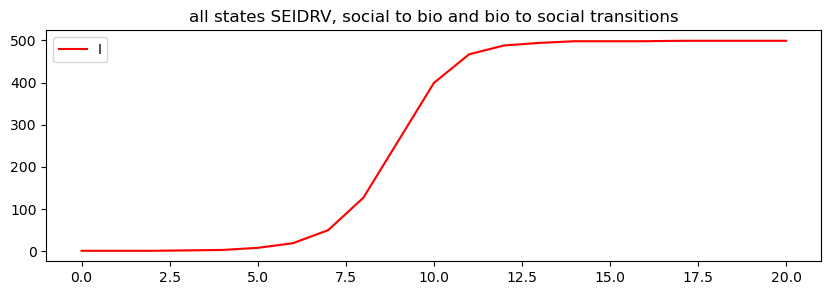

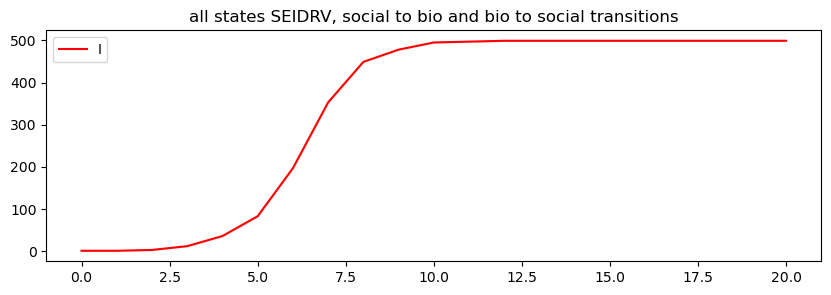

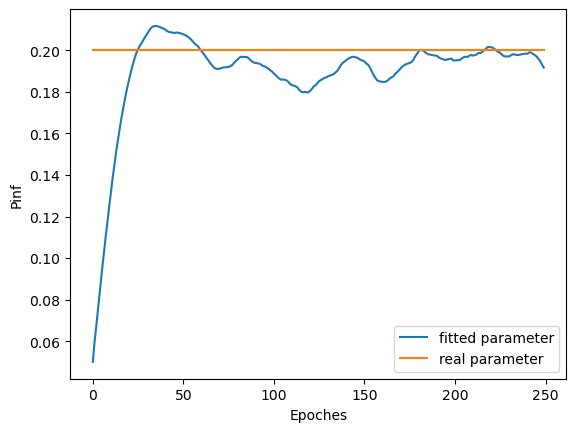

In [61]:
fitPinfs=[]
#gradient direction: negative-> positive
for i in range(250):
    print(i, " ", si_fit._pinf.item())
    optimizer.zero_grad()
    fitPinfs.append(si_fit._pinf.item())
    population = Population(n, device=device)
    si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
    loss = loss_fn(stats_gt, IMeans_pred)
    loss.backward(retain_graph=True)
    optimizer.step()

print_model_parameters(si_fit)
plot(si_pred.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plt.plot(fitPinfs, label='fitted parameter')
plt.plot([pinf]*len(fitPinfs), label='real parameter')
plt.xlabel("Epoches")
plt.ylabel("Pinf")
plt.legend()
